In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
nGauss = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

widths = np.linspace(2, 20, nGauss)

images = torch.zeros(nGauss, 1, imgSize, imgSize)
labels = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    ro = 1.5*np.random.randn(2) # random offset
    G = np.exp( -( (X - ro[0])**2 + (Y - ro[1])**2 ) / (widths[i]) ) # formula for Gaussian

    G = G + np.random.randn(imgSize, imgSize)/5 # adding noise

    labels[i,:,:,:] = torch.Tensor(G).view(1, imgSize, imgSize)

    # adding a bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))

    if np.random.randn() > 0:
        G[i1:i1+2, ] = 1
    else:
        G[:, i1:i1+i2] = 1

    images[i,:,:,:] = torch.Tensor(G).view(1, imgSize, imgSize)


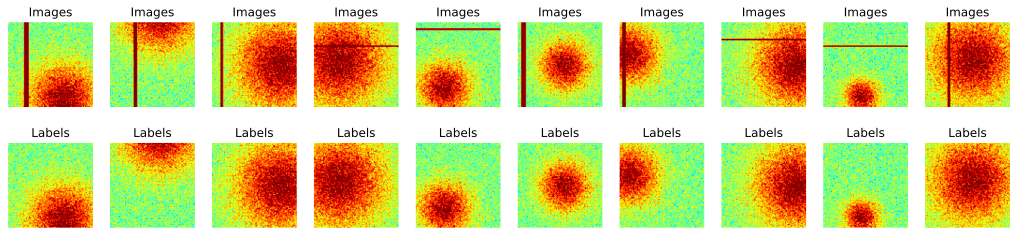

In [4]:
fig, axs = plt.subplots(2, 10, figsize = (18, 4))

for i in range(10):
    whichPic = np.random.randint(nGauss)
    G = np.squeeze(images[whichPic, :, :])
    L = np.squeeze(labels[whichPic, :, :])
    axs[0, i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Images')
    
    axs[1, i].imshow(L, vmin=-1, vmax=1, cmap='jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Labels')
plt.show()

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, train_size=0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [6]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([900, 1, 91, 91])
torch.Size([900, 1, 91, 91])


In [7]:
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

torch.Size([100, 1, 91, 91])
torch.Size([100, 1, 91, 91])


In [8]:
class Model(nn.Module):
    
   def __init__ (self):
      super().__init__()

      self.enc = nn.Sequential(
         nn.Conv2d(1, 6, 3, padding=1),
         nn.ReLU(),
         nn.MaxPool2d(2, 2),
         nn.Conv2d(6, 4, 3, padding=1),
         nn.ReLU(),
         nn.MaxPool2d(2, 2)
      )

      self.dec = nn.Sequential(
         nn.ConvTranspose2d(4, 6, 3, 2),
         nn.ReLU(),
         nn.ConvTranspose2d(6, 1, 3, 2)
      )
    
   def forward(self, x):
      return self.dec(self.enc(x))

In [9]:
def getModel():
    CNN = Model()

    lossFunction = nn.MSELoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [10]:
# testing model

CNN, lossFunction, optimizer = getModel()
X, y = next(iter(train_loader))

yHat = CNN(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossFunction(yHat, y)
print(' ')
print('Loss: ', loss.detach())


 
torch.Size([32, 1, 91, 91])
torch.Size([32, 1, 91, 91])
 
Loss:  tensor(0.1749)


In [11]:
summary(CNN, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

In [18]:
def trainModel(CNN, lossFunction, optimizer):
    epochs = 20

    trainLosses = torch.zeros(epochs)
    trainAcc = []
    testLosses = []

    for _ in range(epochs):

        batchAcc = []
        batchLoss = []

        for x, y in train_loader:

            yHat = CNN(x)
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLosses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))
        with torch.no_grad():
            pred = CNN(X)
            loss = lossFunction(pred, Y)
        testLosses.append(loss.item())


    return trainLosses, testLosses, CNN

In [19]:
CNN, lossFunction, optimizer = getModel()
trainLosses, testLosses, CNN = trainModel(CNN, lossFunction, optimizer)

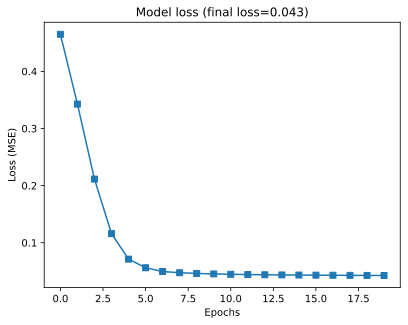

In [20]:
plt.plot(trainLosses, 's-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%trainLosses[-1])

plt.show()

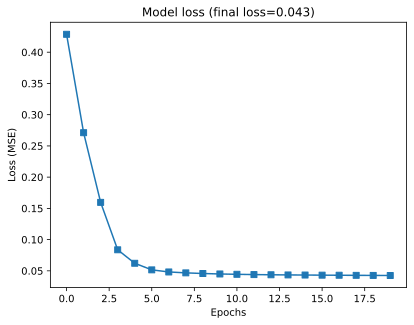

In [21]:
plt.plot(testLosses, 's-', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%testLosses[-1])

plt.show()

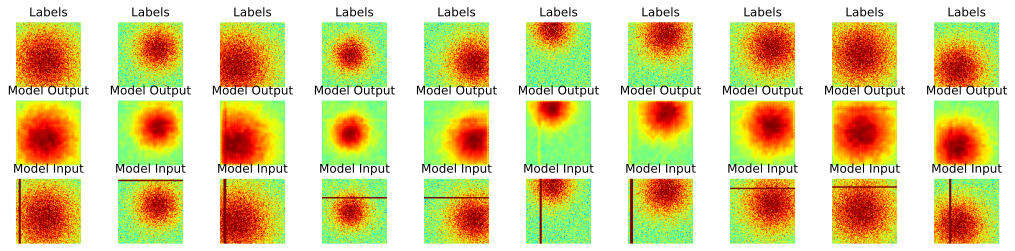

In [22]:
# visualize some images

pics2use = np.random.choice(nGauss, size=32, replace=False)
X, Y = next(iter(test_loader))
yHat = CNN(X)

fig, axs = plt.subplots(3, 10, figsize = (18, 4))

for i in range(10):
    L = torch.squeeze(Y[i, 0, :, :]).detach()
    O = torch.squeeze(yHat[i, 0, :, :]).detach()
    I = torch.squeeze(X[i, 0, :, :]).detach()
    axs[0, i].imshow(L, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Labels')
    
    axs[1, i].imshow(O, vmin=-1, vmax=1, cmap='jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Model Output')

    axs[2, i].imshow(I, vmin=-1, vmax=1, cmap='jet')
    axs[2, i].axis('off')
    axs[2, i].set_title('Model Input')
plt.show()